# Modelo de machine learning para classificação de pacientes com insuficiência cardíaca

## Informações do conjunto de dados

1 - Age: idade do paciente [anos]\
2 - Sex: sexo do paciente [M: Masculino, F: Feminino]\
3 - ChestPainType: tipo de dor torácica [TA: Angina típica, ATA: Angina atípica, NAP: Dor não anginosa, ASY: Assintomática]\
4 - ResgingBP: pressão arterial em repouso [mm Hg]\
5- Cholesterol: colesterol sérico [mm/dl]\
6- FastingBS: glicemia em jejum [1: se BS em jejum > 120 mg/dl, 0: caso contrário]\
7 - ResgingECG: resultados do eletrocardiograma em repouso [Normal: Normal, ST: com anormalidade das ondas ST-T (inversões das ondas T e/ou elevação ou depressão de ST > 0,05 mV), HVE: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de testes]\
8 - MaxHR: frequência cardíaca máxima alcançada [valor numérico entre 60 e 202]\
9 - ExercícioAngina: angina induzida por exercício [Y: Sim, N: Não]\
10 - Oldpeak: oldpeak = ST [Valor numérico medido na depressão]\
11 - ST_Slope: a inclinação do segmento ST do pico do exercício [Up: subida, Flat: flat, Down: downsloping]\
12 - HeartDisease: classe de saída [1: doença cardíaca, 0: Normal]\

### Impotando bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import random


from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear, sigmoid
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

seed = 100
colors = ['#219ebc', '#023047', '#8ecae6', '#ffb703']

### Leitura dos dados

In [2]:
df_original = pd.read_csv('heart.csv')

### Visualizando os dados

In [3]:
df_original.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Verificando o tamanho do dataset

In [4]:
df_original.shape

(918, 12)

### Verificando as informações das variáveis do dataset

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Verificando se existem valores nulos em alguma variável

In [6]:
df_original.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Nota-se que não existe nenhum valor nulo dentro do dataset

### Verificando a quantidade de valores únicos em cada variável

In [7]:
print(df_original.nunique())

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64


## Análise Exploratória

### Estatísticas descritivas

In [8]:
df_original.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Quantidade por sexo

In [9]:
df_original.groupby('Sex').size()

Sex
F    193
M    725
dtype: int64

#### Visualização por gráfico

Text(0, 0.5, 'Quantidade')

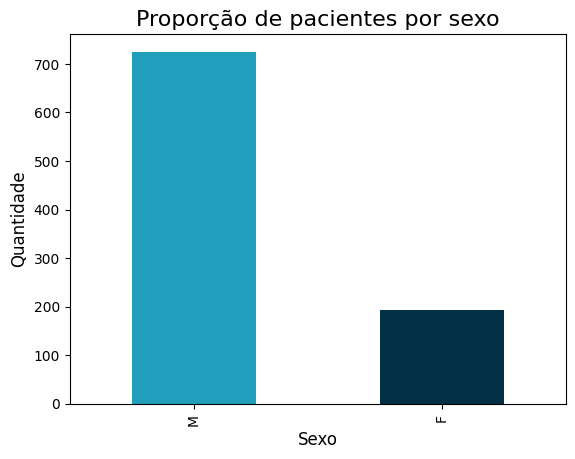

In [10]:
ax = df_original['Sex'].value_counts().plot(kind='bar', color=colors)
ax.set_title('Proporção de pacientes por sexo', fontsize=16)
ax.set_xlabel('Sexo', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)

Nota-se que a quantidade de homens é muito maior do que a de mulheres

### Quantidade por tipo de dor toráxica

In [11]:
df_original.groupby('ChestPainType').size()

ChestPainType
ASY    496
ATA    173
NAP    203
TA      46
dtype: int64

#### Visualização por gráfico

<Axes: title={'center': 'Quantidade por dor tipo de dor toráxica'}, xlabel='Tipo de dor', ylabel='Quantidade'>

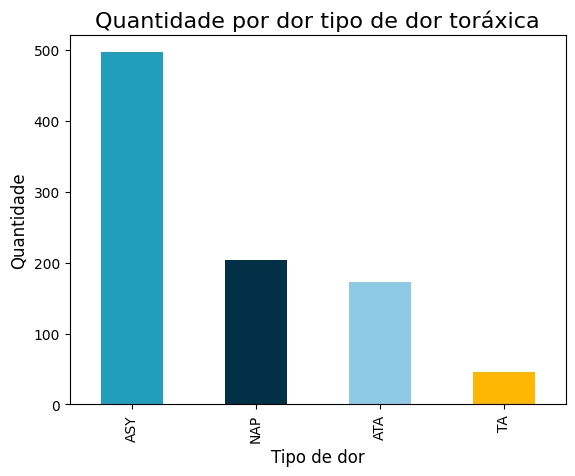

In [12]:
ax = df_original['ChestPainType'].value_counts().plot(kind='bar', color=colors)
ax.set_title('Quantidade por dor tipo de dor toráxica', fontsize=16)
ax.set_xlabel('Tipo de dor', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax

### Quantidade por Glicemia em Jejum

In [13]:
df_original.groupby('FastingBS').size()

FastingBS
0    704
1    214
dtype: int64

#### Visualização por gráfico

<Axes: title={'center': 'Glicemia em Jejum (FastingBS)'}, xlabel='BS em jejum > 120 mg', ylabel='Quantidade'>

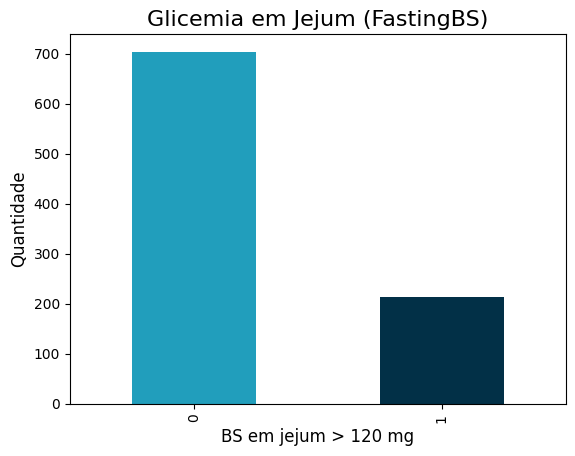

In [14]:
ax = df_original['FastingBS'].value_counts().plot(kind='bar', color=colors)
ax.set_title('Glicemia em Jejum (FastingBS)', fontsize=16)
ax.set_xlabel('BS em jejum > 120 mg', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax

### Quantidade por resultado do eletrocardiograma em repouso

In [15]:
df_original.groupby('RestingECG').size()

RestingECG
LVH       188
Normal    552
ST        178
dtype: int64

#### Visualização por gráfico

<Axes: title={'center': 'Eletrocardiograma em repouso'}, xlabel='RestingECG', ylabel='Quantidade'>

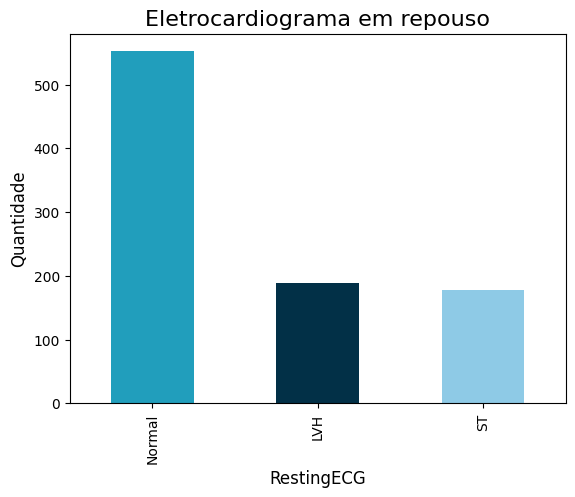

In [16]:
ax = df_original['RestingECG'].value_counts().plot(kind='bar', color=colors)
ax.set_title('Eletrocardiograma em repouso', fontsize=16)
ax.set_xlabel('RestingECG', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax

### Quantidade por classe de Angina Induzida

In [17]:
df_original.groupby('ExerciseAngina').size()

ExerciseAngina
N    547
Y    371
dtype: int64

#### Visualização por gráfico

<Axes: title={'center': 'Angina induzida'}, xlabel='ExreciseAngina', ylabel='Quantidade'>

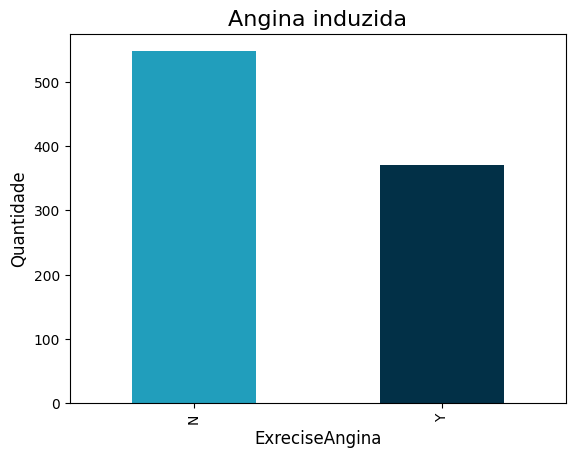

In [18]:
ax = df_original['ExerciseAngina'].value_counts().plot(kind='bar', color=colors)
ax.set_title('Angina induzida', fontsize=16)
ax.set_xlabel('ExreciseAngina', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax

### Quantiade por classe de Inclinação Pico Exercício

In [19]:
df_original.groupby('ST_Slope').size()

ST_Slope
Down     63
Flat    460
Up      395
dtype: int64

#### Vizualização por gráfico

<Axes: title={'center': 'Inclinação Pico Exercício'}, xlabel='ST_Slope', ylabel='Quantidade'>

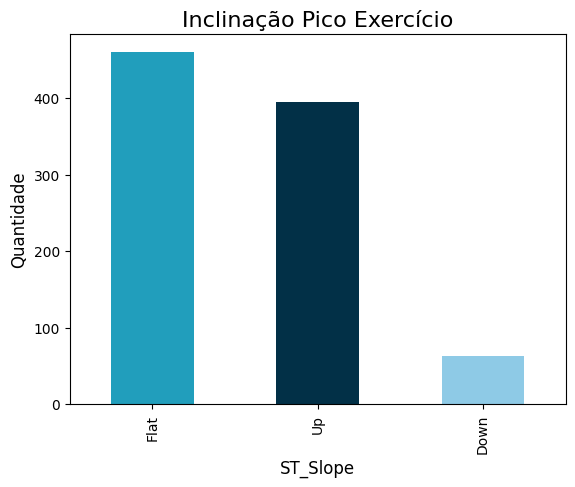

In [20]:
ax = df_original['ST_Slope'].value_counts().plot(kind='bar', color=colors)
ax.set_title('Inclinação Pico Exercício', fontsize=16)
ax.set_xlabel('ST_Slope', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax

### Proporção da variável target (HeartDisease)

In [21]:
df_original.groupby('HeartDisease').size()

HeartDisease
0    410
1    508
dtype: int64

#### Visualização por gráfico

<Axes: title={'center': 'Doença Cardíaca'}, xlabel='HeartDisease', ylabel='Quantidade'>

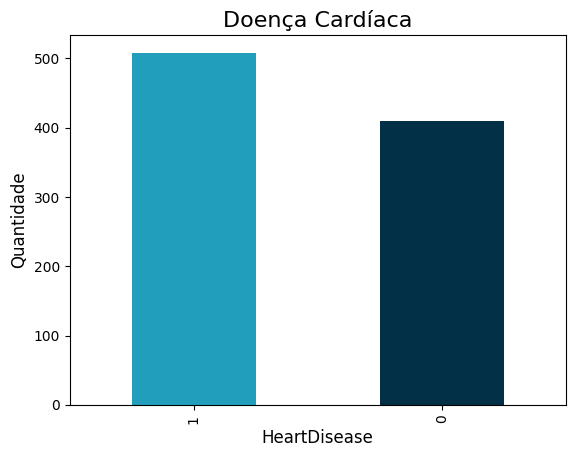

In [22]:
ax = df_original['HeartDisease'].value_counts().plot(kind='bar', color=colors)
ax.set_title('Doença Cardíaca', fontsize=16)
ax.set_xlabel('HeartDisease', fontsize=12)
ax.set_ylabel('Quantidade', fontsize=12)
ax

Nota-se que a maioria dos pacientes registrados no dataset possuem a doença cardíaca

### Analisando variaveis categóricas em relação a variável target

Analisando as linhas iniciais do dataset, no início do programa, e a quantidade de valores únicos por variável, também mostrado anteriormente, podemos ver que as variáveis categóricas são:

<ul>
    <li>Sex</li>
    <li>ChestPainType</li>
    <li>FastingBs</li>
    <li>RestingECG</li>
    <li>ExerciseAngina</li>
    <li>ST_Slope</li>
</ul>

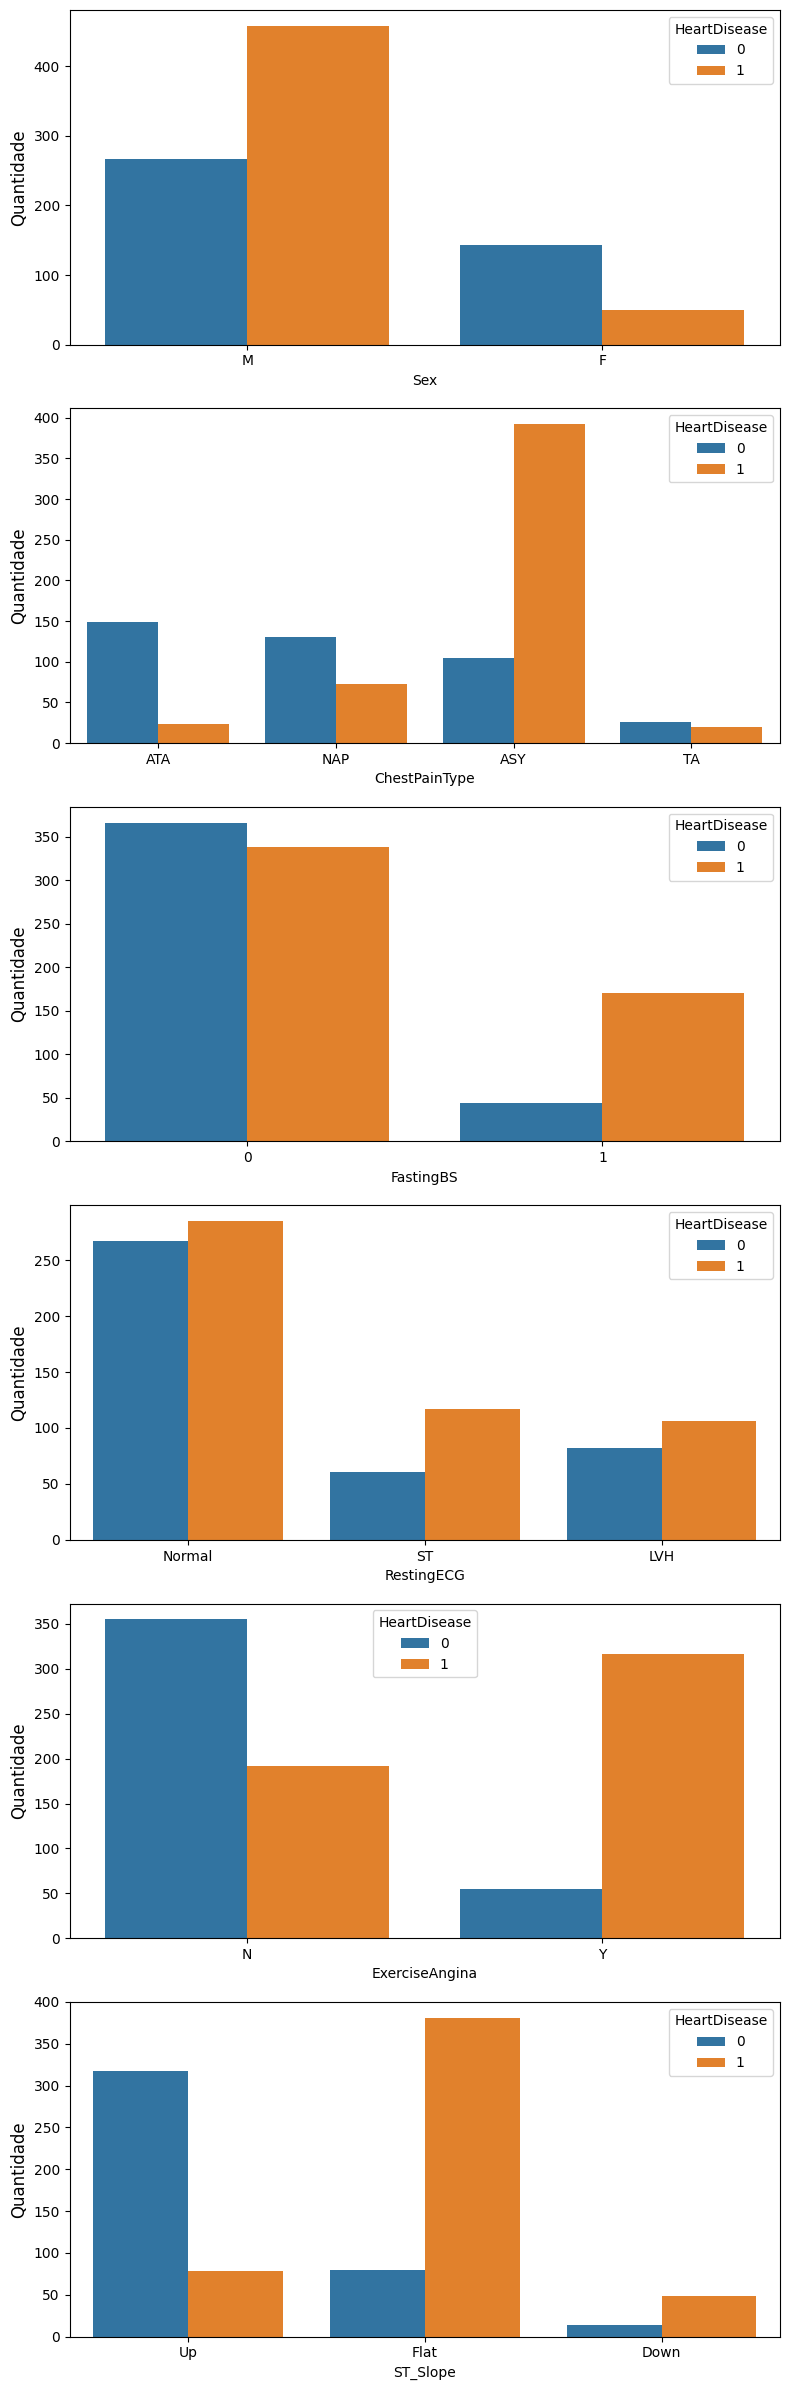

In [23]:
# Loop para plotagem dos gráficos 

categorical_vars = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

_,axes = plt.subplots(6,figsize=(8,24))

for i, var in enumerate(categorical_vars):
    sns.countplot(data = df_original, x=var, hue='HeartDisease', ax=axes[i])
    axes[i].set_ylabel('Quantidade', fontsize=12)
    
plt.tight_layout()
plt.show()

#### Insights dos gráficos

<ul>
    <li><b>Sex:</b> Analisando o gráfico da variável Sex, podemos notar que a quantidade de homens com doença cardíaca é muito maior do que a de homens sem doença cardíaca. Já para as mulheres, a grande maioria das mulheres não possui a doença.</li>
    <li><b>ChestPainType:</b> Analisando o gráfico dessa variável podemos notar a grande predominancia de casos positivos da doença quando o paciente apresenta dores assintomáticas
        (ASY). Logo, podemos constatar que essa classe da variável é determinante na classificação da doença. Quando a dor relatada é angina atípica (ATA) a
        grande maioria dos casos é negativo para a doença, tornando essa classe determinante também para a classificação da doença. Já as demais classes, como Dor não anginosa (NAP) e Angina típica (TA), quando relatadas, na maioria dos casos, os pacientes não possuem a doença, mas ainda assim, boa parte deles apresenta, fazendo com que essas classes não sejam tão determinantes.</li>
    <li><b>FastingBS:</b> Essa variável também aparenta ser muito importante para a classificação da doença. Quando o paciente apresenta glicemia em jejum maior do que 120mg/dl, na grande maioria dos casos, ele possui a doença. Logo, a classe 1 da variável FastingBS possui muita influência na classificação da doença. Quando a classe é 0, ou seja, o valor de glicemia em jejum é menor que 120 mg/dl, é difícil dizer se o paciente possui ou não a doença, visto que a proporção de casos positivos e negativos para essa condição é quase 50%.</li>
    <li><b>RestingECG:</b> A classe ST é a mais determinante para a classificação da doença, visto que ela apresenta uma proporção de casos positivos maior que as outras classes.</li>
    <li><b>ExerciseAngina:</b> Essa variável aparenta ser muito importante para a classificação da doença, todas as suas classes são determinantes. A classe Y (apresenta angina induzida por exercício) é muito determinante, visto que, quando relatada, na grande maioria dos casos, o paciente possui a doença. A classe N (não apresenta angina induzida por exercício) é menos determinante, mas apresenta uma proporção relativamente maior para casos negativos do que positivos da doença.</li>
    <li><b>ST_Slop:</b> Essa variável também aparenta ser muito importante para a classificação da doença. As classes Flat e UP (inclinação do segmento ST do pico do exercício flat e subida, respectivamente) são muito determinantes, pois apresentam proporções muito grandes para casos positivos e negativos da doença, respectivamente. A classe Down (downnsloping) também é determinante, pois a proporção de casos positivos é mais do que duas vezes os negativos para a doença.</li>
</ul>

### Covertendo variáveis do tipo object para o tipo category

Essa conversão será realizada pois as variáveis categóricas ocupam menos espaço na memória.

In [24]:
df_original['Sex'] = df_original['Sex'].astype('category')
df_original['ChestPainType'] = df_original['ChestPainType'].astype('category')
df_original['RestingECG'] = df_original['RestingECG'].astype('category')
df_original['ExerciseAngina'] = df_original['ExerciseAngina'].astype('category')
df_original['ST_Slope'] = df_original['ST_Slope'].astype('category')
df_original['FastingBS'] = df_original['FastingBS'].astype('category')

In [25]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(6), float64(1), int64(5)
memory usage: 49.4 KB


Podemos observar que memória usada pelo dataset diminuiu quase que pela metade com a conversão dos tipos de variáveis. Para um dataset pequeno, como o nosso, isso pode ser irrelevante, mas para grandes volumes de dados isso pode influenciar muito.

### Boxplots das variáveis numéricas

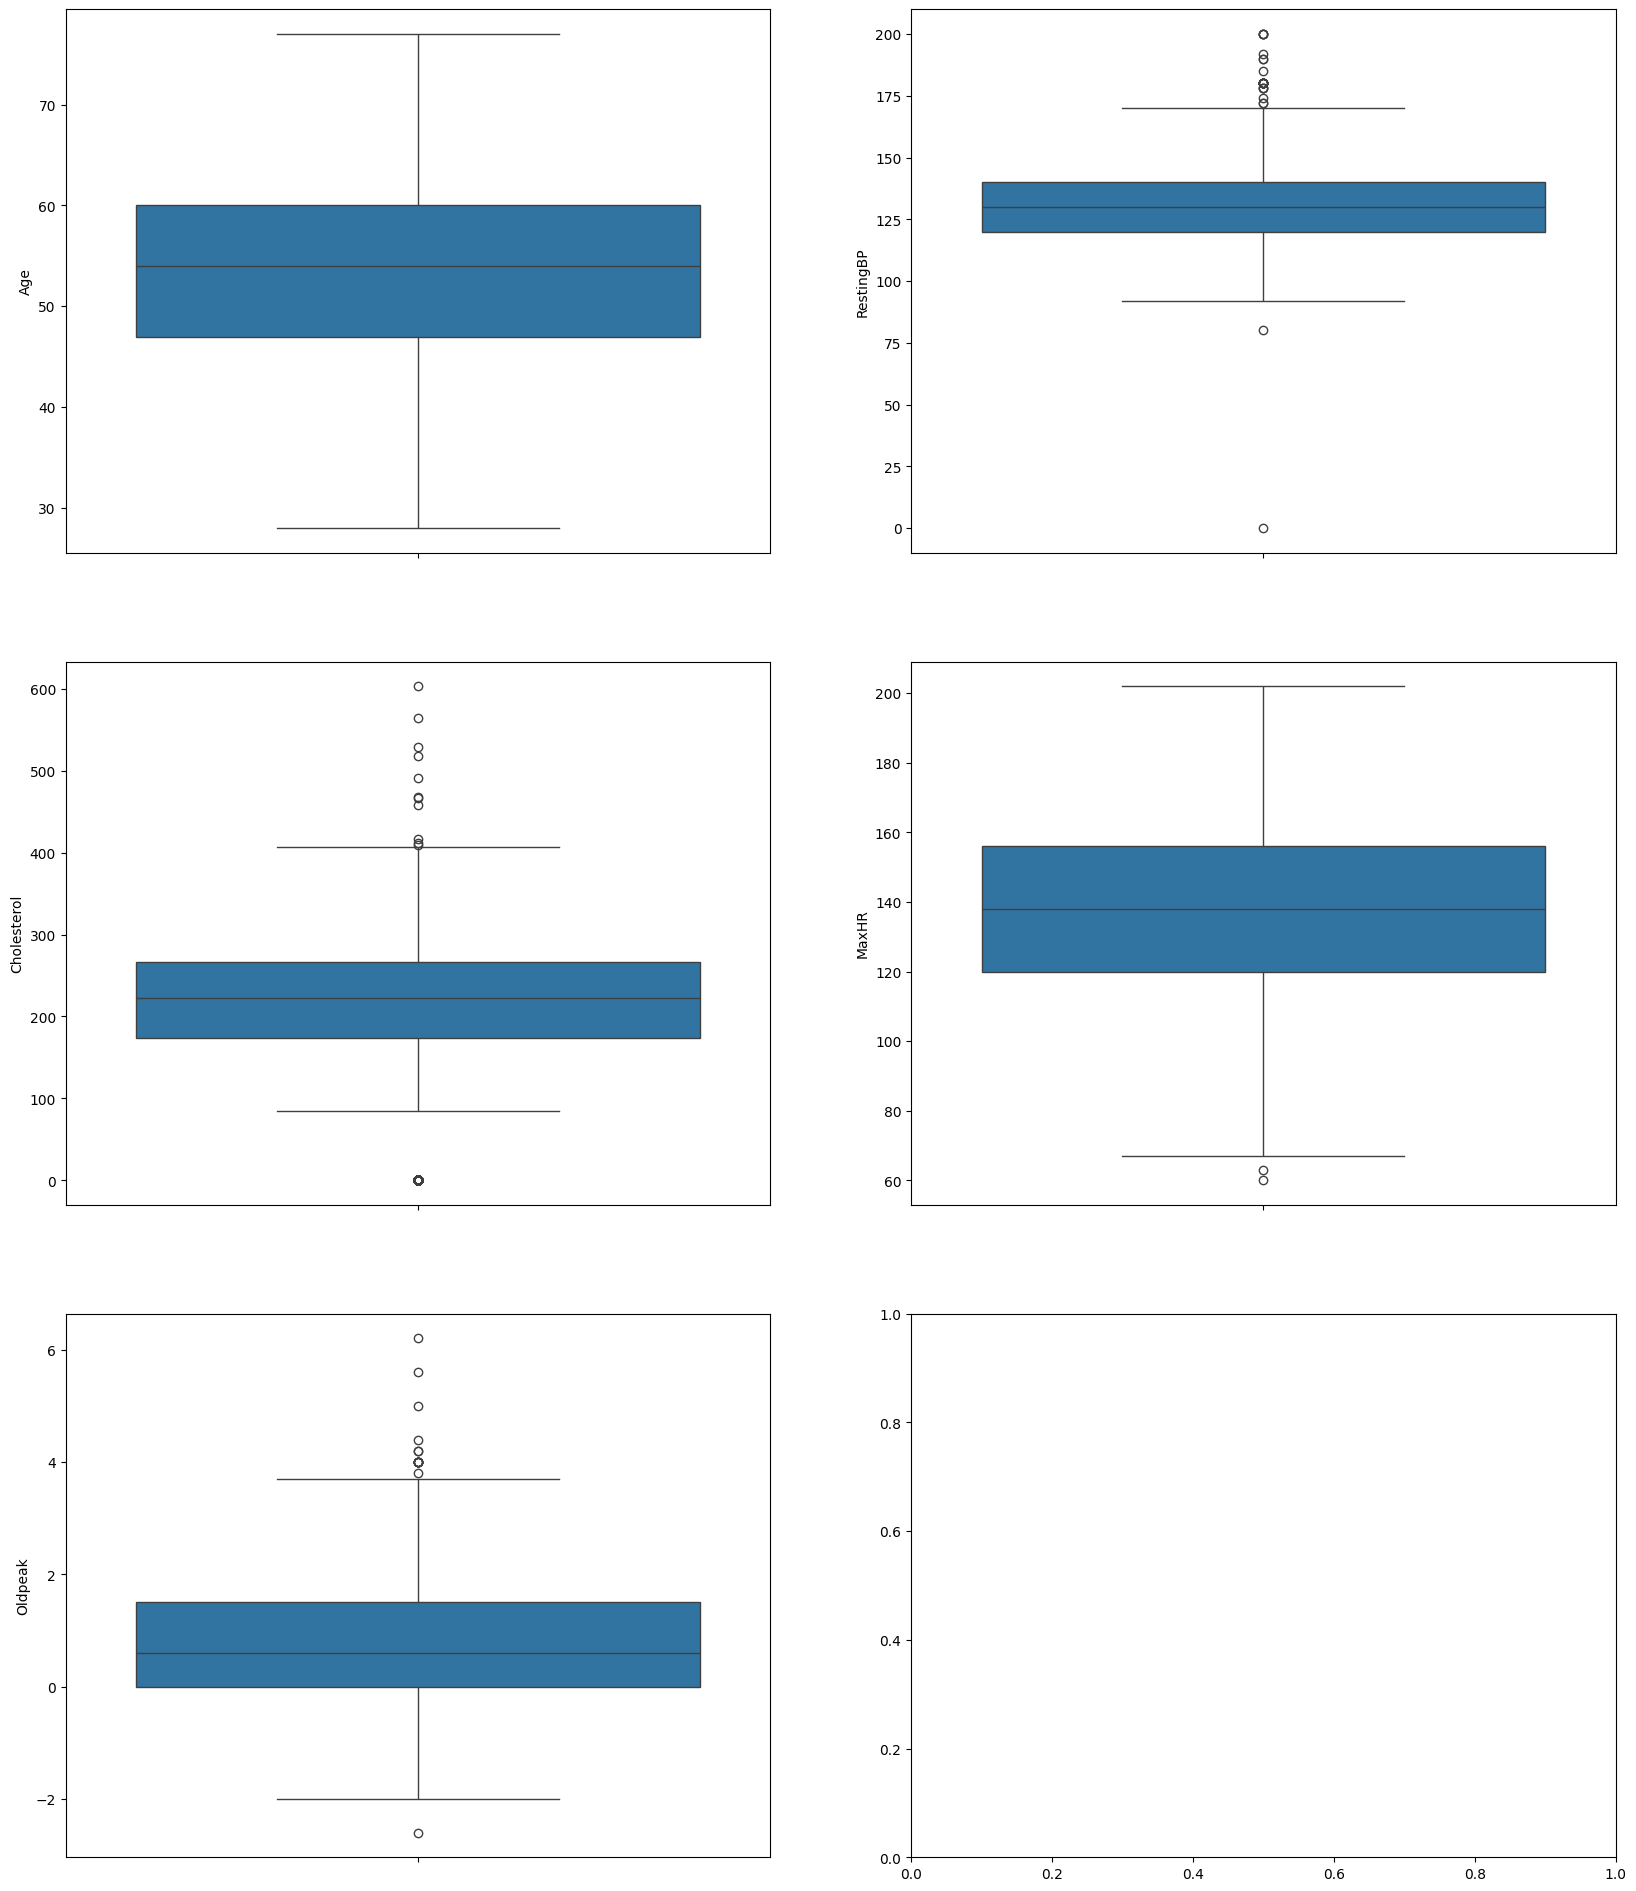

In [26]:
_,axes = plt.subplots(3,2,figsize=(20,24))

line = 0
col = 0

for i in df_original.columns[:-1]:
    if df_original.dtypes[i] != 'category':
        sns.boxplot(data = df_original, y=i, ax=axes[line,col])
        col+=1
        if col>1:
            col=0
            line+=1
plt.show()

#### Insight dos gráficos

<ul>
    <li><b>Age:</b> Essa variável não apresenta outliers.</li>
    <li><b>RestingBP:</b> Essa variável apresenta valores considerados como possíveis outliers. Entretanto, foram realizadas algumas pesquisas para familiarizar-se com a natureza dos dados e observou-se que, em casos de crise hipertensiva, a pressão arterial em repouso pode apresentar valores em torno de 200, o que mostra que os dados são reais e não outliers. Existe também uma única ocorrência, que é mostrada na célula abaixo, com valor de pressão arterial em repoudo de 0 mmHG, o que pode indicar que o paciente teve uma parada cardíaca. Com isso, podemos concluir que todos os dados são reais.</li>
    <li><b>Cholesterol:</b> Essa variável apresenta possíveis outliers em torno de 600 mg/dl e 0 mg/dl. Pesquisando na literatura, conclui-se que os valores em torno de 600 mg/dl são reais. Isso pode se dar por uma condição genética rara, chamada hipercolesterolemia familiar, por isso, manteremos esses dados. Os valores de 0 mg/dl são impossíveis em condições normais e podem indicar falhas nos métodos ou equipamentos de medição. Por isso, iremos verificar a quantidade de ocorências dessa condição e tratá-la mais adiante.</li>
    <li><b>MaxHR:</b> Essa variável apresenta possíveis outliers em torno de 60. Entretanto, pesquisando na literatura e, como já especificado na seção Informações do conjunto de dados, conclui-se que esses valores são reais e não outliers.</li>
    <li><b>Oldpeak:</b> Pesquisando na lieratura, cocnlui-se que esses valores são reais e não outliers. Os valores negativos representam depressão do segmento ST e os valores positivos representam elevação do segmento ST.</li>
</ul>

#### Verificando paciente com pressão arterial em repouso de 0mmHG

In [27]:
df_original[df_original['RestingBP'] < 10]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


#### Verificando pacientes com colesterol igual a zero

In [28]:
df_original[df_original['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


Notas-se que um valor expressivo de pacientes apresentou a condição de cholesterol sérico igual a zero. Como o dataset é relativamente pequeno, não iremos remover esses dados. Iremos substituílos pela mediana dos valores. Escolheremos a mediana pois ela é menos sensível à presença de outliers.

Antes de tratar essa variável, iremos plotar, na seção seguinte, os histogramas das variáveis para conhecermos a suas distribuições de frequência.

### Distribuições de frequência das variáveis numéricas

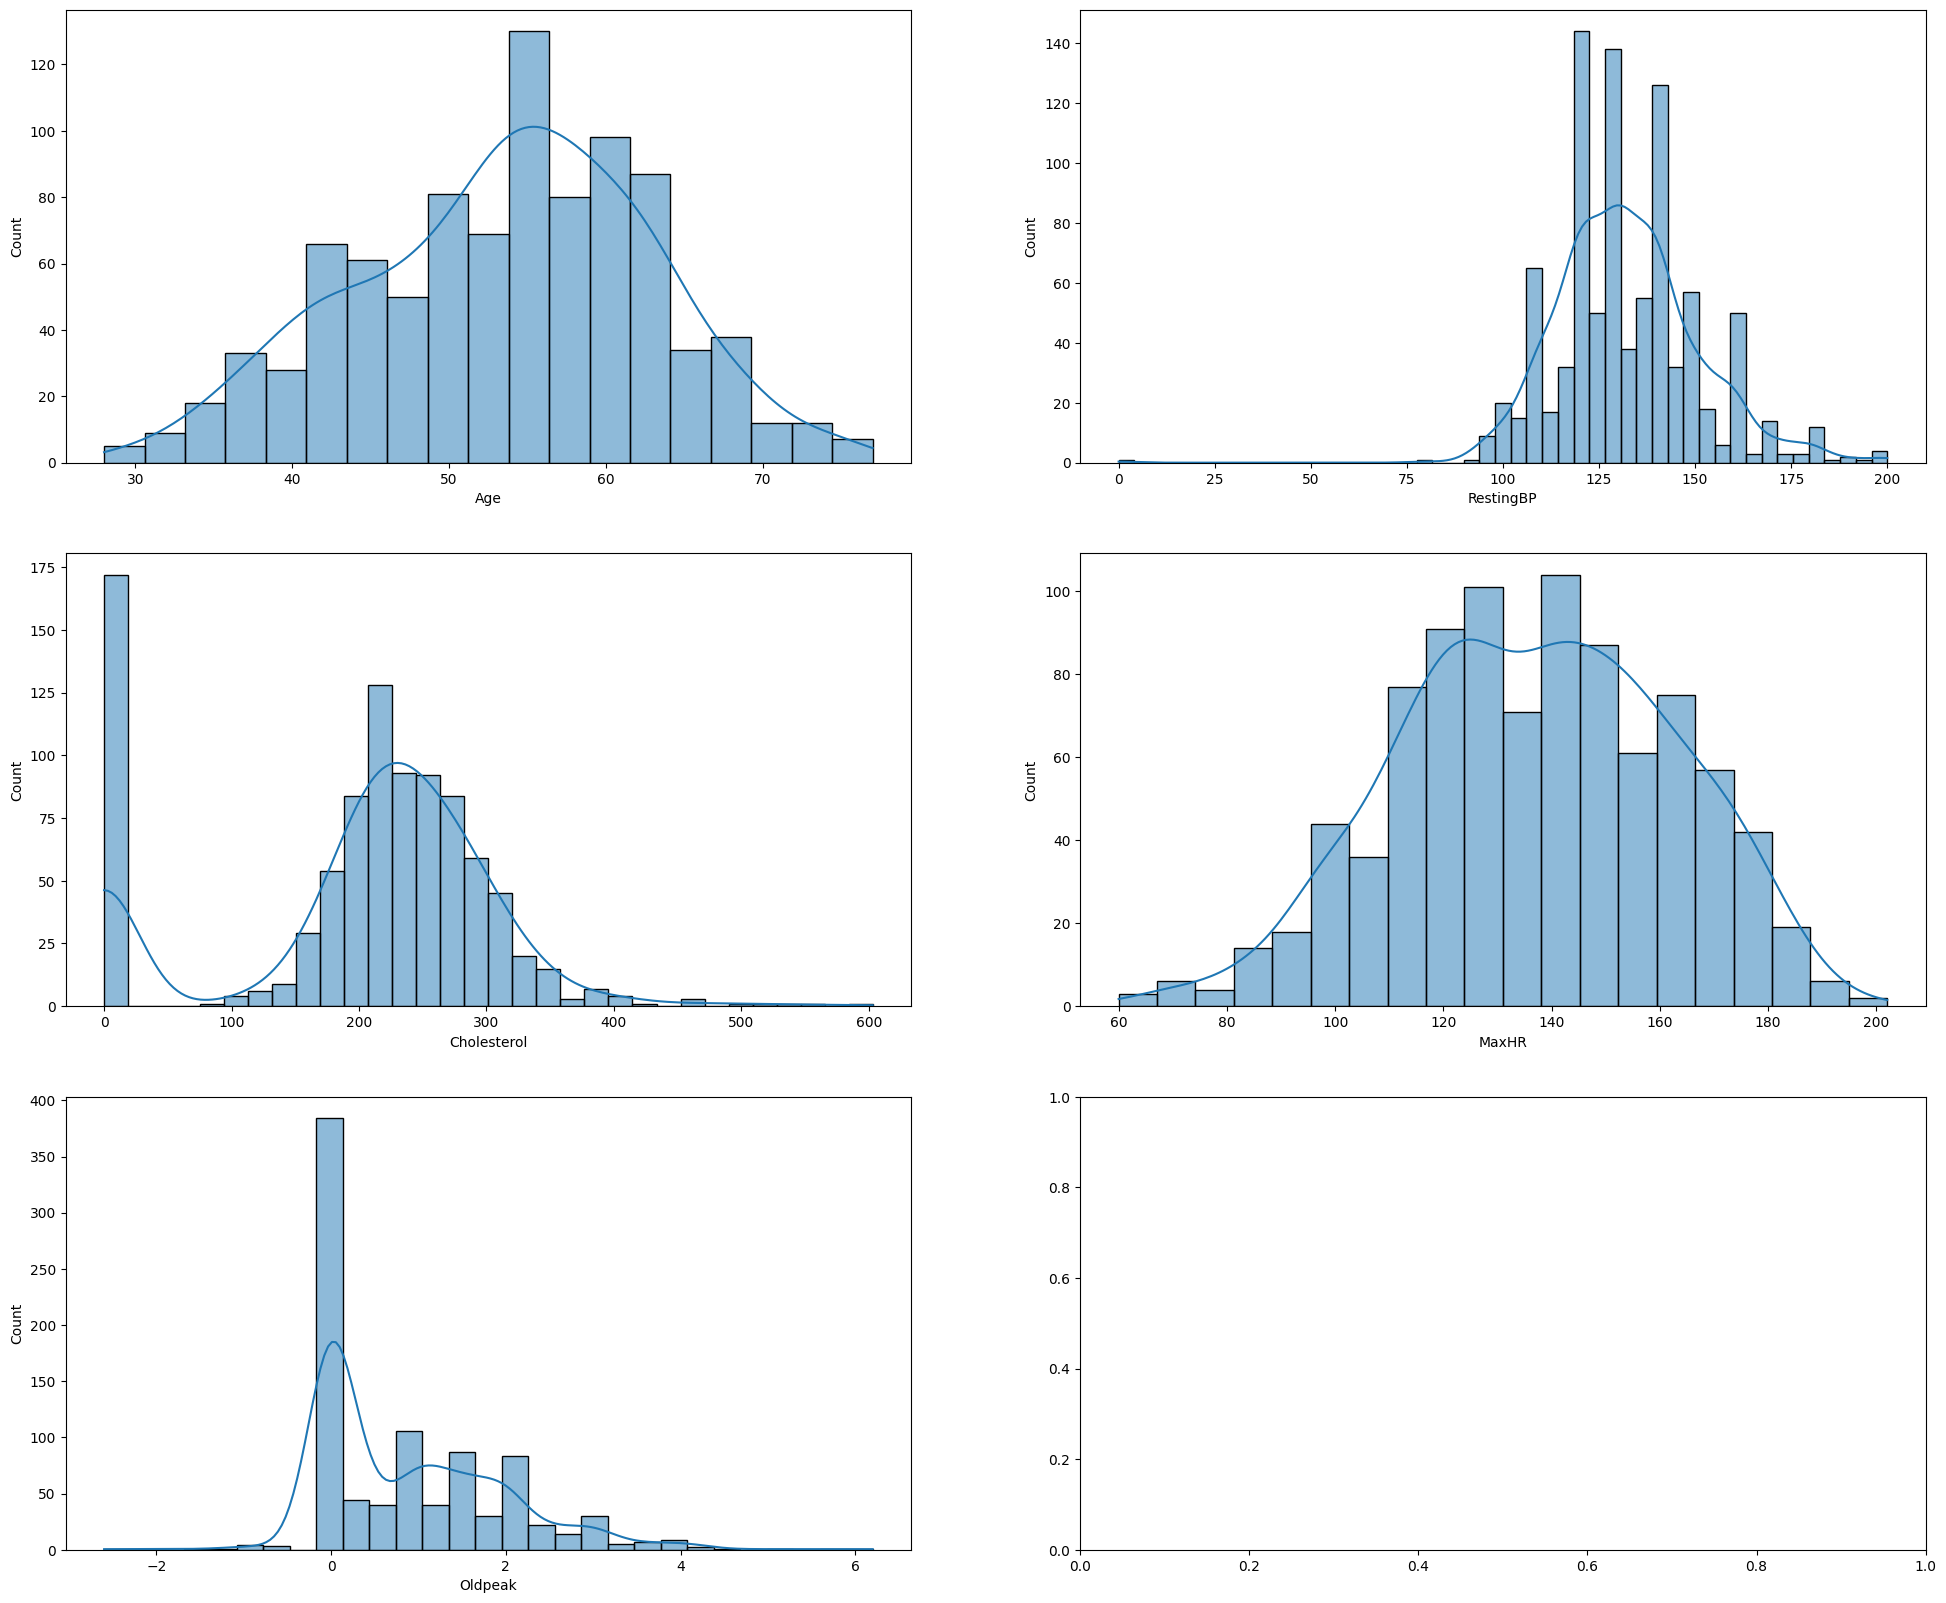

In [29]:
_,axes = plt.subplots(3,2,figsize=(24,20))

line = 0
col = 0

for i in df_original.columns[:-1]:
    if df_original.dtypes[i] != 'category':
        sns.histplot(data=df_original[i], kde=True, ax=axes[line,col])
        col+=1
        if col>1:
            col=0
            line+=1

plt.show()

#### Insights dos gráfcos

Observando os gráficos, podemos notar que o nível de colesterol sérico de 0 mg/dl apresenta a maior concentração de pacientes, ou seja, o valor com maior incidência é justamente um possível outlier.

Observa-se também que o valor predominante na variável Oldpeak é o valor de zero. Esse valor indica uae a inclinação do segmento ST é plana e alinhada com a linha base do ECG, caracterizando-a como inclinação normal.

### Verificando o balancemaneto da variável target

In [30]:
df_original['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

## Tratamento dos dados

Nesta seção, iremos criar pipelines para tratamento dos dados.

### Separando variáveis catecógicas e numéticas

In [31]:
var_categoricas = []
var_numericas = []

for i in df_original.columns[:-1]:
    if df_original.dtypes[i] == 'category':
        var_categoricas.append(i)
    else:
        var_numericas.append(i)

### Pipeline de pré-processamento

<UL>
    <li>Como mencionado nas seções anteriores, iremos substituir os valores zero na variável Cholesterol pela sua mediana.</li>
    <li>Utilizaremos MinMaxScaler para normalizar os valores numéricos.</li>
    <li>Utilizaremos OneHotEncoder para as variáveis categoricas.</li>
</UL>

In [32]:
pipeline_preprocessamento = ColumnTransformer([
    ('imputer', SimpleImputer(strategy='median', missing_values=0), ['Cholesterol']),
    ('scaler', MinMaxScaler(), var_numericas),
    ('encoder', OneHotEncoder(handle_unknown='ignore'), var_categoricas)
])

### Dividindo o dataset em treino e teste

In [33]:
X = df_original.drop('HeartDisease', axis=1)
y = df_original['HeartDisease']

model_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=model_seed)

## Criando, Treinando e Avaliando os Modelos de Machine Learning

Iremos criar modelos de Random Forest, XGBoost e Regressão Logística. Iremos avaliar os modelos e depois tunar os hiperparâmetros de cada um e, ao final, escolheremos o melhor

In [34]:
pipeline_rf = Pipeline([
    ('preprocessing', pipeline_preprocessamento),
    ('classifier', RandomForestClassifier(random_state=model_seed))
])

In [35]:
pipeline_xgb = Pipeline([
    ('preprocessing', pipeline_preprocessamento),
    ('classifier', xgb.XGBClassifier(random_state=model_seed))
])

In [36]:
pipeline_lr = Pipeline([
    ('preprocessing', pipeline_preprocessamento),
    ('classifier', LogisticRegression(random_state=model_seed))
])

In [37]:
rf = pipeline_rf.fit(X_train,y_train)

In [38]:
xgb = pipeline_xgb.fit(X_train,y_train)

In [39]:
lr = pipeline_lr.fit(X_train,y_train)

Para a avaliação dos modelos, utilizaremos cross_val_score

In [40]:
cross_val = KFold(n_splits=10, shuffle=True, random_state=model_seed)

In [41]:
acuracia_rf = cross_val_score(rf, X_train, y_train, cv=cross_val).mean()
acuracia_xgb = cross_val_score(xgb, X_train, y_train, cv=cross_val).mean()
acuracia_lr = cross_val_score(lr, X_train, y_train, cv=cross_val).mean()

In [42]:
print('Acurácia do modelo de Random Forest: ', acuracia_rf)
print('Acurácia do modelo de XGBoost: ', acuracia_xgb)
print('Acurácia do modelo de Regressão Logística: ', acuracia_lr)

Acurácia do modelo de Random Forest:  0.853533653846154
Acurácia do modelo de XGBoost:  0.8505048076923079
Acurácia do modelo de Regressão Logística:  0.8488701923076925


Podemos notar que o modelo de Random Forest performou pouco melhor. Iremos fazer ajuste de hiperparâmetros e escolheremos o modelo que apresentar o melhor resultado

## Ajuste de hiperparâmetros

utilizaremos GridSearchCV para encontrar os melhores hiperparâmetros

### Random Forest

In [43]:
rf_params = {
    'classifier__n_estimators': [100, 150, 200, 250, 300, 350, 400],
    'classifier__max_depth': [5, 7, 10, 12, 15],
    'classifier__criterion': ['entropy', 'gini'],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_split': [1, 2, 3, 4, 5],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__bootstrap': [True, False]

}

In [44]:
grid_search = GridSearchCV(pipeline_rf, rf_params, cv=cross_val, n_jobs=-1)

In [45]:
inicio = time.time()
grid_search.fit(X_train,y_train)
fim = time.time()

In [46]:
grid_search_trains = pd.DataFrame(grid_search.cv_results_)

In [47]:
print(f'Acurácia em treinamento: {grid_search.best_score_ :.2%}')
print('')
print(f'Hiperparametros Ideais: {grid_search.best_params_}')
print('')
print('Tempo de treinamento do modelo: ', round(fim-inicio,2))
print('')
print('Número de treinamentos realizados: ', grid_search_trains.shape[0])

Acurácia em treinamento: 87.22%

Hiperparametros Ideais: {'classifier__bootstrap': True, 'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 400}

Tempo de treinamento do modelo:  1201.28

Número de treinamentos realizados:  4200


In [48]:
rf_best_model = grid_search.best_estimator_
acuracia_rf_best_model = cross_val_score(pipeline_rf, X_train, y_train, cv=cross_val).mean()
print('Acurácia do modelo de Random Forest para validação cruzada: ', acuracia_rf_best_model)

Acurácia do modelo de Random Forest para validação cruzada:  0.853533653846154


Podemos notar que o desempenho do modelo foi exatamente o mesmo do Random Forest sem o ajuste dos hiperparâmetros. Iremos agora testar os outros modelos.

### XGBoost

In [49]:
xgb_params = {
    'classifier__n_estimators': [100, 200, 300, 400, 500, 600],
    'classifier__max_depth': [3, 6, 9, 12, 15],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3]
}

In [50]:
grid_search = GridSearchCV(pipeline_xgb, xgb_params, cv=cross_val, n_jobs=-1)

In [51]:
inicio = time.time()
grid_search.fit(X_train,y_train)
fim = time.time()

In [52]:
grid_search_trains = pd.DataFrame(grid_search.cv_results_)

In [53]:
print(f'Acurácia em treinamento: {grid_search.best_score_ :.2%}')
print('')
print(f'Hiperparametros Ideais: {grid_search.best_params_}')
print('')
print('Tempo de treinamento do modelo: ', round(fim-inicio,2))
print('')
print('Número de treinamentos realizados: ', grid_search_trains.shape[0])

Acurácia em treinamento: 86.14%

Hiperparametros Ideais: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}

Tempo de treinamento do modelo:  29.77

Número de treinamentos realizados:  120


In [54]:
xgb_best_model = grid_search.best_estimator_
acuracia_xgb_best_model = cross_val_score(pipeline_xgb, X_train, y_train, cv=cross_val).mean()
print('Acurácia do modelo de XGBoost para validação cruzada: ', acuracia_xgb_best_model)

Acurácia do modelo de XGBoost para validação cruzada:  0.8505048076923079


Novamente obteve-se o mesmo desempenho do modelo sem o ajuste dos hiperparâmetros.

### Regressão Logística

In [55]:
lr_params = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__max_iter': [100, 200, 300],
    'classifier__tol': [1e-4, 1e-3],
}

In [56]:
grid_search = GridSearchCV(pipeline_lr, lr_params, cv=cross_val, n_jobs=-1)


In [57]:
inicio = time.time()
grid_search.fit(X_train,y_train)
fim = time.time()

In [58]:
grid_search_trains = pd.DataFrame(grid_search.cv_results_)

In [59]:
print(f'Acurácia em treinamento: {grid_search.best_score_ :.2%}')
print('')
print(f'Hiperparametros Ideais: {grid_search.best_params_}')
print('')
print('Tempo de treinamento do modelo: ', round(fim-inicio,2))
print('')
print('Número de treinamentos realizados: ', grid_search_trains.shape[0])

Acurácia em treinamento: 86.13%

Hiperparametros Ideais: {'classifier__C': 0.01, 'classifier__max_iter': 300, 'classifier__penalty': None, 'classifier__tol': 0.0001}

Tempo de treinamento do modelo:  2.94

Número de treinamentos realizados:  120


In [60]:
lr_best_model = grid_search.best_estimator_
acuracia_lr_best_model = cross_val_score(pipeline_lr, X_train, y_train, cv=cross_val).mean()
print('Acurácia do modelo de Regressão Logística para validação cruzada: ', acuracia_lr_best_model)

Acurácia do modelo de Regressão Logística para validação cruzada:  0.8488701923076925


Nota-se que o modelo de regressão logística também apresentou o mesmo resultado que sem o ajuste de hiperparâmetros.

## Avaliação dos modelos

Para escolhermos o melhor modelo para ir para produção, não avaliaremos apenas pela acurácia, iremos analisar também as métricas de recall, precision e f1-score de cada modelo.

### Random Forest

In [61]:
y_pred = pipeline_rf.predict(X_test)

In [62]:
cm = confusion_matrix(y_test, y_pred)

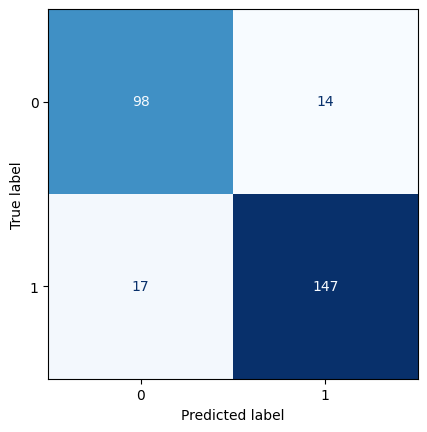

In [63]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot(include_values=True, cmap='Blues', colorbar=None)

In [64]:
print('Métricas de avaliação do modelo de Random Forest: \n', classification_report(y_test, y_pred))

Métricas de avaliação do modelo de Random Forest: 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       112
           1       0.91      0.90      0.90       164

    accuracy                           0.89       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.89      0.89       276



### XGBoost

In [65]:
y_pred = pipeline_xgb.predict(X_test)

In [66]:
cm = confusion_matrix(y_test, y_pred)

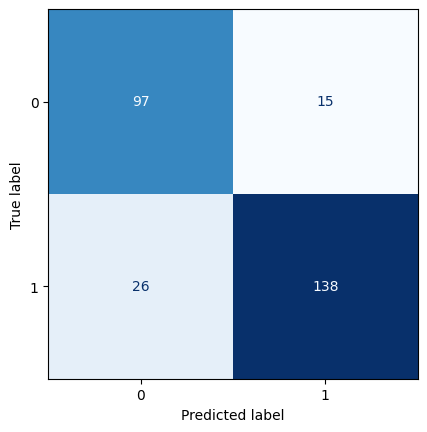

In [67]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot(include_values=True, cmap='Blues', colorbar=None)

In [68]:
print('Métricas de avaliação do modelo de XGBoost: \n', classification_report(y_test, y_pred))

Métricas de avaliação do modelo de XGBoost: 
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       112
           1       0.90      0.84      0.87       164

    accuracy                           0.85       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.86      0.85      0.85       276



### Regressão Loística

In [69]:
y_pred = pipeline_lr.predict(X_test)

In [70]:
cm = confusion_matrix(y_test, y_pred)

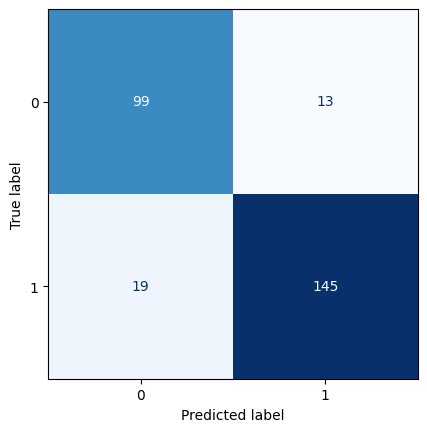

In [71]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot(include_values=True, cmap='Blues', colorbar=None)

In [72]:
print('Métricas de avaliação do modelo de Regressão logística: \n', classification_report(y_test, y_pred))

Métricas de avaliação do modelo de Regressão logística: 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       112
           1       0.92      0.88      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.89      0.88      0.88       276



Observando as matrizes de confusão acima e as metricas de recall, precision e f1-score, podemos notar que, apesar de todos os três modelos apresentarem acurácias semelhantes, eles se diferem nas outras métricas. Para esse projeto, iremos escolher o modelo que apresentou o melhor Recall, que foi o Random Forest, visto que essa métrica foca na proporção de casos positivos que foram corretamente classificados. Como se trata de uma doença séria, queremos identificar o máximo possível de casos positivos e queremos ter o mínimo de casos falso negativos.

## Conclusões

Com o desenvolvimento do projeto, conseguimos obter um recall de 90% para o modelo do tipo Random Forest. Esse, aparentemente é um bom resultado. Entretanto, como se trata de uma doença, podemos almejar resultados melhores.

Para melhorarmos essa métrica, uma das posibilidades seria coletar mais dados, visto que a coleta de mais dados tende a melhorar o desempenho de modelos que apresentam high bias, como é o caso do nosso modelo. Outra possibilidade, e que será abordada em um trabalho futuro, é realizar feature engineering.